**CIN0137 - Banco de Dados**
# Recife ITBI ETL Data Pipeline

This project presents a complete ETL (Extract, Transform, Load) pipeline for Recife's ITBI (Imposto de Transmissão de Bens Imóveis) datasets covering the years 2023, 2024, and 2025. The notebook demonstrates robust data extraction, cleaning, visualization,transformation, and consolidation processes, followed by insertion into a PostgreSQL database.

## SETUP

This section prepares the environment for the Recife ITBI Data Pipeline project. Here, we install and import all necessary Python libraries for data extraction, transformation, analysis, and database integration. The setup ensures your system is ready to process ITBI datasets and interact with PostgreSQL.

**Required Libraries:**

- **numpy**: Numerical operations and array handling
- **pandas**: Data manipulation and analysis
- **zipfile**: File compression and extraction
- **os**: File system operations
- **datetime**: Date and time utilities
- **psycopg2**: PostgreSQL database adapter
- **sqlalchemy**: Database toolkit for Python
- **json**: Configuration file management

In [418]:
# Importing libraries required to clean, standardize, and prepare the dataset for futher analysis.

import math
import numpy as np
import pandas as pd
import zipfile
import os
from datetime import datetime
import json
import psycopg2
import sqlalchemy
from psycopg2 import sql
from sqlalchemy import create_engine
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

import time
start_time  = time.time()

**Data Loading**

After installing and importing the libraries, the setup phase also loads the ITBI datasets for the years 2023, 2024, and 2025 directly from the Recife open data portal. The datasets are read into pandas DataFrames and stored for further ETL processing. This ensures that all data is available and ready for cleaning, transformation, and analysis in the subsequent steps.

In [419]:
# Define the directory path where datasets will be stored
dataset_directory = "datasets"

# Create the directory if it doesn't exist, avoiding errors if it already exists
os.makedirs(dataset_directory, exist_ok=True)

# Define dataset URLs
dataset_sources = {
    "2023": "http://dados.recife.pe.gov.br/dataset/28e3e25e-a9a7-4a9f-90a8-bb02d09cbc18/resource/d0c08a6f-4c27-423c-9219-8d13403816f4/download/itbi_2023.csv",
    "2024": "http://dados.recife.pe.gov.br/dataset/28e3e25e-a9a7-4a9f-90a8-bb02d09cbc18/resource/a36d548b-d705-496a-ac47-4ec36f068474/download/itbi_2024.csv",
    "2025": "http://dados.recife.pe.gov.br/dataset/28e3e25e-a9a7-4a9f-90a8-bb02d09cbc18/resource/5b582147-3935-459a-bbf7-ee623c22c97b/download/itbi_2025.csv"
}

datasets_dict = {}  # Dictionary to store the datasets

for load_year, data_url in dataset_sources.items():
    try:
        # Try to load the CSV
        temp_dataframe = pd.read_csv(data_url, sep=';', encoding='utf-8')
        
        # Check if DataFrame is not empty
        if temp_dataframe.empty:
            raise ValueError("Dataset loaded is empty")
        
        # Save dataset in dictionary for later manipulation
        datasets_dict[load_year] = temp_dataframe.copy()  # Create an independent copy
        
    except Exception as load_error:
        print(f"Error loading data for {load_year}: {type(load_error).__name__}")
        print(f"Details: {str(load_error)}")
        del load_error

# Clean up loop variables
del load_year, data_url, temp_dataframe

staging_dataset = pd.concat(datasets_dict.values(), ignore_index=True)
print(staging_dataset.info())
staging_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35117 entries, 0 to 35116
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   logradouro          35117 non-null  object 
 1   numero              35117 non-null  int64  
 2   complemento         31778 non-null  object 
 3   valor_avaliacao     35117 non-null  object 
 4   bairro              35117 non-null  object 
 5   cidade              35117 non-null  object 
 6   uf                  35117 non-null  object 
 7   ano_construcao      35117 non-null  int64  
 8   area_terreno        35117 non-null  object 
 9   area_construida     35117 non-null  object 
 10  fracao_ideal        35117 non-null  object 
 11  padrao_acabamento   35117 non-null  object 
 12  tipo_construcao     35117 non-null  object 
 13  tipo_ocupacao       35117 non-null  object 
 14  data_transacao      35117 non-null  object 
 15  estado_conservacao  35117 non-null  object 
 16  tipo

,logradouro,numero,complemento,valor_avaliacao,bairro,cidade,uf,ano_construcao,area_terreno,area_construida,...,tipo_construcao,tipo_ocupacao,data_transacao,estado_conservacao,tipo_imovel,sfh,cod_logradouro,latitude,longitude,ano
0,av norte miguel arraes de alencar,3071,NaN,"1068562,63",Encruzilhada,Recife,PE,1997,"438,0","511,0",...,Galpão,COMERCIAL COM LIXO ORGANICO,2023-12-21,Regular,Galpão,"0,00",46540,-8.034273,-34.896337,2023
1,av norte miguel arraes de alencar,3029,NaN,"1500000,00",Encruzilhada,Recife,PE,1957,"779,33","582,44",...,Casa,COMERCIAL SEM LIXO ORGANICO,2023-11-17,Regular,Casa,"0,00",46540,-8.034435,-34.896335,2023
2,rua belmiro corrêa,133,apto 0001,"110000,00",Encruzilhada,Recife,PE,1970,"562,05","121,0",...,Apartamento <= 4 Pavimentos,RESIDENCIAL,2023-09-26,Bom,Apartamento,"0,00",10715,-8.035013,-34.895903,2023
3,rua belmiro corrêa,133,apto 0001,"110000,00",Encruzilhada,Recife,PE,1970,"562,05","121,0",...,Apartamento <= 4 Pavimentos,RESIDENCIAL,2023-09-22,Bom,Apartamento,"0,00",10715,-8.035013,-34.895903,2023
4,rua belmiro corrêa,133,apto 0002,"110000,00",Encruzilhada,Recife,PE,1970,"562,05","81,0",...,Apartamento <= 4 Pavimentos,RESIDENCIAL,2023-09-22,Bom,Apartamento,"0,00",10715,-8.035013,-34.895903,2023


## Data Cleaning

**Renaming unclear columns**

In [420]:
def rename_sfh_column(df):
    """
    Renomeia a coluna 'sfh' para 'valores_financiados_sfh' para melhor clareza
    
    Args:
        df (pd.DataFrame): DataFrame com dados ITBI
    
    Returns:
        pd.DataFrame: DataFrame com coluna renomeada
    """
    df_transformed = df.rename(columns={'sfh': 'valores_financiados_sfh'})
    print(f"Coluna 'sfh' renomeada para 'valores_financiados_sfh'")
    return df_transformed

staging_dataset = rename_sfh_column(staging_dataset)
staging_dataset.head()

Coluna 'sfh' renomeada para 'valores_financiados_sfh'


,logradouro,numero,complemento,valor_avaliacao,bairro,cidade,uf,ano_construcao,area_terreno,area_construida,...,tipo_construcao,tipo_ocupacao,data_transacao,estado_conservacao,tipo_imovel,valores_financiados_sfh,cod_logradouro,latitude,longitude,ano
0,av norte miguel arraes de alencar,3071,NaN,"1068562,63",Encruzilhada,Recife,PE,1997,"438,0","511,0",...,Galpão,COMERCIAL COM LIXO ORGANICO,2023-12-21,Regular,Galpão,"0,00",46540,-8.034273,-34.896337,2023
1,av norte miguel arraes de alencar,3029,NaN,"1500000,00",Encruzilhada,Recife,PE,1957,"779,33","582,44",...,Casa,COMERCIAL SEM LIXO ORGANICO,2023-11-17,Regular,Casa,"0,00",46540,-8.034435,-34.896335,2023
2,rua belmiro corrêa,133,apto 0001,"110000,00",Encruzilhada,Recife,PE,1970,"562,05","121,0",...,Apartamento <= 4 Pavimentos,RESIDENCIAL,2023-09-26,Bom,Apartamento,"0,00",10715,-8.035013,-34.895903,2023
3,rua belmiro corrêa,133,apto 0001,"110000,00",Encruzilhada,Recife,PE,1970,"562,05","121,0",...,Apartamento <= 4 Pavimentos,RESIDENCIAL,2023-09-22,Bom,Apartamento,"0,00",10715,-8.035013,-34.895903,2023
4,rua belmiro corrêa,133,apto 0002,"110000,00",Encruzilhada,Recife,PE,1970,"562,05","81,0",...,Apartamento <= 4 Pavimentos,RESIDENCIAL,2023-09-22,Bom,Apartamento,"0,00",10715,-8.035013,-34.895903,2023


**Remove geographic redundant columns**

In [421]:
def remove_redundant_geographic_columns(df):
    """
    Remove colunas geográficas redundantes ('cidade' e 'uf') 
    pois contêm apenas valores uniformes (Recife e PE)
    
    Args:
        df (pd.DataFrame): DataFrame com dados ITBI
    
    Returns:
        pd.DataFrame: DataFrame sem colunas redundantes
    """
    columns_to_drop = ['cidade', 'uf']
    existing_columns = [col for col in columns_to_drop if col in df.columns]
    
    if existing_columns:
        df_transformed = df.drop(existing_columns, axis=1)
        print(f"Colunas removidas: {existing_columns}")
    else:
        df_transformed = df.copy()
        print("Erro: Colunas 'cidade' e 'uf' não encontradas")
    
    return df_transformed

staging_dataset = remove_redundant_geographic_columns(staging_dataset)
staging_dataset.head()

Colunas removidas: ['cidade', 'uf']


,logradouro,numero,complemento,valor_avaliacao,bairro,ano_construcao,area_terreno,area_construida,fracao_ideal,padrao_acabamento,tipo_construcao,tipo_ocupacao,data_transacao,estado_conservacao,tipo_imovel,valores_financiados_sfh,cod_logradouro,latitude,longitude,ano
0,av norte miguel arraes de alencar,3071,NaN,"1068562,63",Encruzilhada,1997,"438,0","511,0","1,0",Médio,Galpão,COMERCIAL COM LIXO ORGANICO,2023-12-21,Regular,Galpão,"0,00",46540,-8.034273,-34.896337,2023
1,av norte miguel arraes de alencar,3029,NaN,"1500000,00",Encruzilhada,1957,"779,33","582,44","1,0",Médio,Casa,COMERCIAL SEM LIXO ORGANICO,2023-11-17,Regular,Casa,"0,00",46540,-8.034435,-34.896335,2023
2,rua belmiro corrêa,133,apto 0001,"110000,00",Encruzilhada,1970,"562,05","121,0","0,27191",Simples,Apartamento <= 4 Pavimentos,RESIDENCIAL,2023-09-26,Bom,Apartamento,"0,00",10715,-8.035013,-34.895903,2023
3,rua belmiro corrêa,133,apto 0001,"110000,00",Encruzilhada,1970,"562,05","121,0","0,27191",Simples,Apartamento <= 4 Pavimentos,RESIDENCIAL,2023-09-22,Bom,Apartamento,"0,00",10715,-8.035013,-34.895903,2023
4,rua belmiro corrêa,133,apto 0002,"110000,00",Encruzilhada,1970,"562,05","81,0","0,18202",Simples,Apartamento <= 4 Pavimentos,RESIDENCIAL,2023-09-22,Bom,Apartamento,"0,00",10715,-8.035013,-34.895903,2023


**Convert values to appropriate types**

In [422]:
def standardize_decimal_format(value):
    """
    Converte formato decimal brasileiro (vírgula) para formato internacional (ponto)
    
    Args:
        value: Valor a ser convertido
    
    Returns:
        str: Valor com formato decimal padronizado
    """
    if pd.isna(value):
        return value
    return str(value).replace(',', '.')

def convert_valor_avaliacao_to_float(df):
    """
    Converte coluna 'valor_avaliacao' de object para float
    após padronizar o formato decimal
    
    Args:
        df (pd.DataFrame): DataFrame com dados ITBI
    
    Returns:
        pd.DataFrame: DataFrame com valor_avaliacao como float
    """
    df_transformed = df.copy()
    
    if 'valor_avaliacao' in df_transformed.columns:
        # Padronizar formato decimal (vírgula para ponto)
        df_transformed['valor_avaliacao'] = df_transformed['valor_avaliacao'].apply(standardize_decimal_format)
        
        # Converter para float
        df_transformed['valor_avaliacao'] = df_transformed['valor_avaliacao'].astype('float')
    
    return df_transformed

def convert_to_category(df):

    """
    Convert specific object columns to category type for better memory usage and performance
    
    Args:
        df (pd.DataFrame): DataFrame with ITBI data
    
    Returns:
        pd.DataFrame: DataFrame with categorical columns optimized
    """
    
    df_transformed = df.copy()
    
    # Define columns that should be categorical
    categorical_columns = ['padrao_acabamento', 'tipo_construcao', 'tipo_ocupacao', 'estado_conservacao', 'tipo_imovel', 'ano']
    
    
    for column in categorical_columns:
        if column in df_transformed.columns:
            # Convert to category
            df_transformed[column] = df_transformed[column].astype('category')
    
    return df_transformed
    
def convert_area_terreno_to_float(df):
    """
    Converte coluna 'area_terreno' de object para float
    após padronizar o formato decimal
    
    Args:
        df (pd.DataFrame): DataFrame com dados ITBI
    
    Returns:
        pd.DataFrame: DataFrame com area_terreno como float
    """
    df_transformed = df.copy()
    
    if 'area_terreno' in df_transformed.columns:
        # Padronizar formato decimal e converter para float
        df_transformed['area_terreno'] = (df_transformed['area_terreno']
                                        .astype(str)
                                        .str.replace(',', '.')
                                        .astype(float))
    
    return df_transformed

def convert_area_construida_to_float(df):
    """
    Converte coluna 'area_construida' de object para float
    após padronizar o formato decimal
    
    Args:
        df (pd.DataFrame): DataFrame com dados ITBI
    
    Returns:
        pd.DataFrame: DataFrame com area_construida como float
    """
    df_transformed = df.copy()
    
    if 'area_construida' in df_transformed.columns:
        # Padronizar formato decimal e converter para float
        df_transformed['area_construida'] = (df_transformed['area_construida']
                                           .astype(str)
                                           .str.replace(',', '.')
                                           .astype(float))
    
    return df_transformed

def convert_fracao_ideal_to_float(df):
    df_transformed = df.copy()

    if 'fracao_ideal' in df_transformed.columns:
        df_transformed['fracao_ideal'] = (df_transformed['fracao_ideal'].astype(str).str.replace(',','.').astype(float))

    
    return df_transformed


def convert_data_transacao_to_timestamp(df):

    df_transformed = df.copy()

    if 'data_transacao' in df_transformed.columns :
        df_transformed['data_transacao'] = pd.to_datetime(df_transformed['data_transacao'])

    return df_transformed


def convert_valores_financiados_sfh_to_float(df):

    df_transformed = df.copy()

    if 'valores_financiados_sfh' in df_transformed.columns :
        df_transformed['valores_financiados_sfh'] = (df_transformed['valores_financiados_sfh'].astype(str).str.replace(',', '.').astype(float)) 

    return df_transformed

def convert_complemento_to_object(df):
    """ Converts the 'complemento' column to object type
    Args:
        df (pd.DataFrame): DataFrame with ITBI data
    Returns:
        pd.DataFrame: DataFrame with 'complemento' as object type
    """
    df_transformed = df.copy()
    if 'complemento' in df_transformed.columns:
        df_transformed['complemento'] = df_transformed['complemento'].astype(object)
    
    return df_transformed

def convert_to_appropiate_types(df):
    df_transformed = df.copy()

    df_transformed = convert_valor_avaliacao_to_float(df_transformed)
    df_transformed = convert_to_category(df_transformed)
    df_transformed = convert_area_terreno_to_float(df_transformed)
    df_transformed = convert_area_construida_to_float(df_transformed)
    df_transformed = convert_data_transacao_to_timestamp(df_transformed)
    df_transformed = convert_fracao_ideal_to_float(df_transformed)
    df_transformed = convert_valores_financiados_sfh_to_float(df_transformed)
    df_transformed = convert_complemento_to_object(df_transformed)
    return df_transformed

staging_dataset = convert_to_appropiate_types(staging_dataset)
print(staging_dataset.info())
staging_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35117 entries, 0 to 35116
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   logradouro               35117 non-null  object        
 1   numero                   35117 non-null  int64         
 2   complemento              31778 non-null  object        
 3   valor_avaliacao          35117 non-null  float64       
 4   bairro                   35117 non-null  object        
 5   ano_construcao           35117 non-null  int64         
 6   area_terreno             35117 non-null  float64       
 7   area_construida          35117 non-null  float64       
 8   fracao_ideal             35117 non-null  float64       
 9   padrao_acabamento        35117 non-null  category      
 10  tipo_construcao          35117 non-null  category      
 11  tipo_ocupacao            35117 non-null  category      
 12  data_transacao           35117 n

,logradouro,numero,complemento,valor_avaliacao,bairro,ano_construcao,area_terreno,area_construida,fracao_ideal,padrao_acabamento,tipo_construcao,tipo_ocupacao,data_transacao,estado_conservacao,tipo_imovel,valores_financiados_sfh,cod_logradouro,latitude,longitude,ano
0,av norte miguel arraes de alencar,3071,NaN,1068562.63,Encruzilhada,1997,438.00,511.00,1.00000,Médio,Galpão,COMERCIAL COM LIXO ORGANICO,2023-12-21,Regular,Galpão,0.0,46540,-8.034273,-34.896337,2023
1,av norte miguel arraes de alencar,3029,NaN,1500000.00,Encruzilhada,1957,779.33,582.44,1.00000,Médio,Casa,COMERCIAL SEM LIXO ORGANICO,2023-11-17,Regular,Casa,0.0,46540,-8.034435,-34.896335,2023
2,rua belmiro corrêa,133,apto 0001,110000.00,Encruzilhada,1970,562.05,121.00,0.27191,Simples,Apartamento <= 4 Pavimentos,RESIDENCIAL,2023-09-26,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023
3,rua belmiro corrêa,133,apto 0001,110000.00,Encruzilhada,1970,562.05,121.00,0.27191,Simples,Apartamento <= 4 Pavimentos,RESIDENCIAL,2023-09-22,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023
4,rua belmiro corrêa,133,apto 0002,110000.00,Encruzilhada,1970,562.05,81.00,0.18202,Simples,Apartamento <= 4 Pavimentos,RESIDENCIAL,2023-09-22,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023


**Fix encoding issues**

In [423]:
def fix_encoding_issues(text_value):
    """
    Corrige problemas de encoding em caracteres portugueses
    Converte Latin1 mal interpretado para UTF-8 correto
    
    Args:
        text_value: Valor de texto a ser corrigido
    
    Returns:
        str: Texto com encoding corrigido
    """
    if not isinstance(text_value, str):
        return text_value
    try:
        return text_value.encode('latin1').decode('utf-8')
    except (UnicodeEncodeError, UnicodeDecodeError):
        return text_value

def fix_text_encoding(df):
    """
    Aplica correção de encoding em todas as colunas de texto do DataFrame
    
    Args:
        df (pd.DataFrame): DataFrame com dados ITBI
    
    Returns:
        pd.DataFrame: DataFrame com encoding corrigido
    """
    df_transformed = df.copy()
    
    # Identificar colunas de texto
    text_columns = df_transformed.select_dtypes(include=['object', 'category']).columns
    
    if len(text_columns) > 0:
        for col in text_columns:
            df_transformed[col] = df_transformed[col].apply(fix_encoding_issues)
        
        print(f"Encoding corrigido em {len(text_columns)} colunas de texto")
    else:
        print("Nenhuma coluna de texto encontrada")
    
    return df_transformed

staging_dataset = fix_text_encoding(staging_dataset)

Encoding corrigido em 9 colunas de texto


**Handle missing values**

In [424]:
def handle_missing_values_complemento(df):
    """
    Trata valores ausentes na coluna 'complemento' substituindo por 'não informado'
    
    Args:
        df (pd.DataFrame): DataFrame com dados ITBI
    
    Returns:
        pd.DataFrame: DataFrame com valores ausentes em 'complemento' tratados
    """
    df_transformed = df.copy()
    if 'complemento' in df_transformed.columns:
        # Substituir valores ausentes por 'não informado'
        df_transformed['complemento'] = df_transformed['complemento'].fillna('não informado')
        print("Valores ausentes na coluna 'complemento' foram substituídos por 'não informado'")
    return df_transformed

staging_dataset = handle_missing_values_complemento(staging_dataset)
staging_dataset.head()

Valores ausentes na coluna 'complemento' foram substituídos por 'não informado'


,logradouro,numero,complemento,valor_avaliacao,bairro,ano_construcao,area_terreno,area_construida,fracao_ideal,padrao_acabamento,tipo_construcao,tipo_ocupacao,data_transacao,estado_conservacao,tipo_imovel,valores_financiados_sfh,cod_logradouro,latitude,longitude,ano
0,av norte miguel arraes de alencar,3071,não informado,1068562.63,Encruzilhada,1997,438.00,511.00,1.00000,Médio,Galpão,COMERCIAL COM LIXO ORGANICO,2023-12-21,Regular,Galpão,0.0,46540,-8.034273,-34.896337,2023
1,av norte miguel arraes de alencar,3029,não informado,1500000.00,Encruzilhada,1957,779.33,582.44,1.00000,Médio,Casa,COMERCIAL SEM LIXO ORGANICO,2023-11-17,Regular,Casa,0.0,46540,-8.034435,-34.896335,2023
2,rua belmiro corrêa,133,apto 0001,110000.00,Encruzilhada,1970,562.05,121.00,0.27191,Simples,Apartamento <= 4 Pavimentos,RESIDENCIAL,2023-09-26,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023
3,rua belmiro corrêa,133,apto 0001,110000.00,Encruzilhada,1970,562.05,121.00,0.27191,Simples,Apartamento <= 4 Pavimentos,RESIDENCIAL,2023-09-22,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023
4,rua belmiro corrêa,133,apto 0002,110000.00,Encruzilhada,1970,562.05,81.00,0.18202,Simples,Apartamento <= 4 Pavimentos,RESIDENCIAL,2023-09-22,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023


**Separating additional information from category 'tipo_construcao'**

In [ ]:
import re

def parse_pavimentos(tipo_construcao):
        """
        Parse the construction type string to extract floor information
        """
        if pd.isna(tipo_construcao):
            return 'não especificado'
        
        tipo_str = str(tipo_construcao).lower()
        
        # Check for specific patterns
        if '<= 4 pavimentos' in tipo_str or '<=4 pavimentos' in tipo_str:
            return '<= 4 pavimentos'
        elif '> 4 pavimentos' in tipo_str or '>4 pavimentos' in tipo_str:
            return '> 4 pavimentos'
        
        return 'não especificado'

def clean_tipo_construcao(tipo_construcao):
        """
        Remove pavimento information from the construction type string
        """
        if pd.isna(tipo_construcao):
            return tipo_construcao
        
        tipo_str = str(tipo_construcao)
        
        # Remove pavimento patterns (case insensitive)
        # Remove operators with numbers and pavimentos
        cleaned = re.sub(r'\s*[<>=]*\s*\d+\s*pavimentos?\s*', '', tipo_str, flags=re.IGNORECASE)
        
        # Clean up extra spaces and leading/trailing whitespace
        cleaned = re.sub(r'\s+', ' ', cleaned).strip()
        
        return cleaned

def extract_pavimentos(df, column_name='tipo_construcao'):
    """
    Extract the number of floors (pavimentos) from construction type column
    and create a new column 'quantidade_pavimentos'.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the construction type data
    column_name (str): Name of the column containing construction type info
    
    Returns:
    pd.DataFrame: DataFrame with new 'quantidade_pavimentos' column
    """
    
    # Create a copy of the dataframe to avoid modifying the original
    df_transformed = df.copy()
    
    # Apply the parsing function to create the new column
    df_transformed['quantidade_pavimentos'] = df_transformed[column_name].apply(parse_pavimentos).astype('category')

    df_transformed['tipo_construcao'] = df_transformed[column_name].apply(clean_tipo_construcao).astype('category')
    
    return df_transformed

staging_dataset = extract_pavimentos(staging_dataset)
print(staging_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35117 entries, 0 to 35116
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       35117 non-null  int64         
 1   numero                   35117 non-null  int64         
 2   complemento              35117 non-null  object        
 3   valor_avaliacao          35117 non-null  float64       
 4   ano_construcao           35117 non-null  int64         
 5   area_terreno             35117 non-null  float64       
 6   area_construida          35117 non-null  float64       
 7   fracao_ideal             35117 non-null  float64       
 8   padrao_acabamento        35117 non-null  category      
 9   tipo_construcao          35117 non-null  object        
 10  tipo_ocupacao            35117 non-null  category      
 11  data_transacao           35117 non-null  datetime64[ns]
 12  estado_conservacao       35117 n

## Data Visualization

**By category**

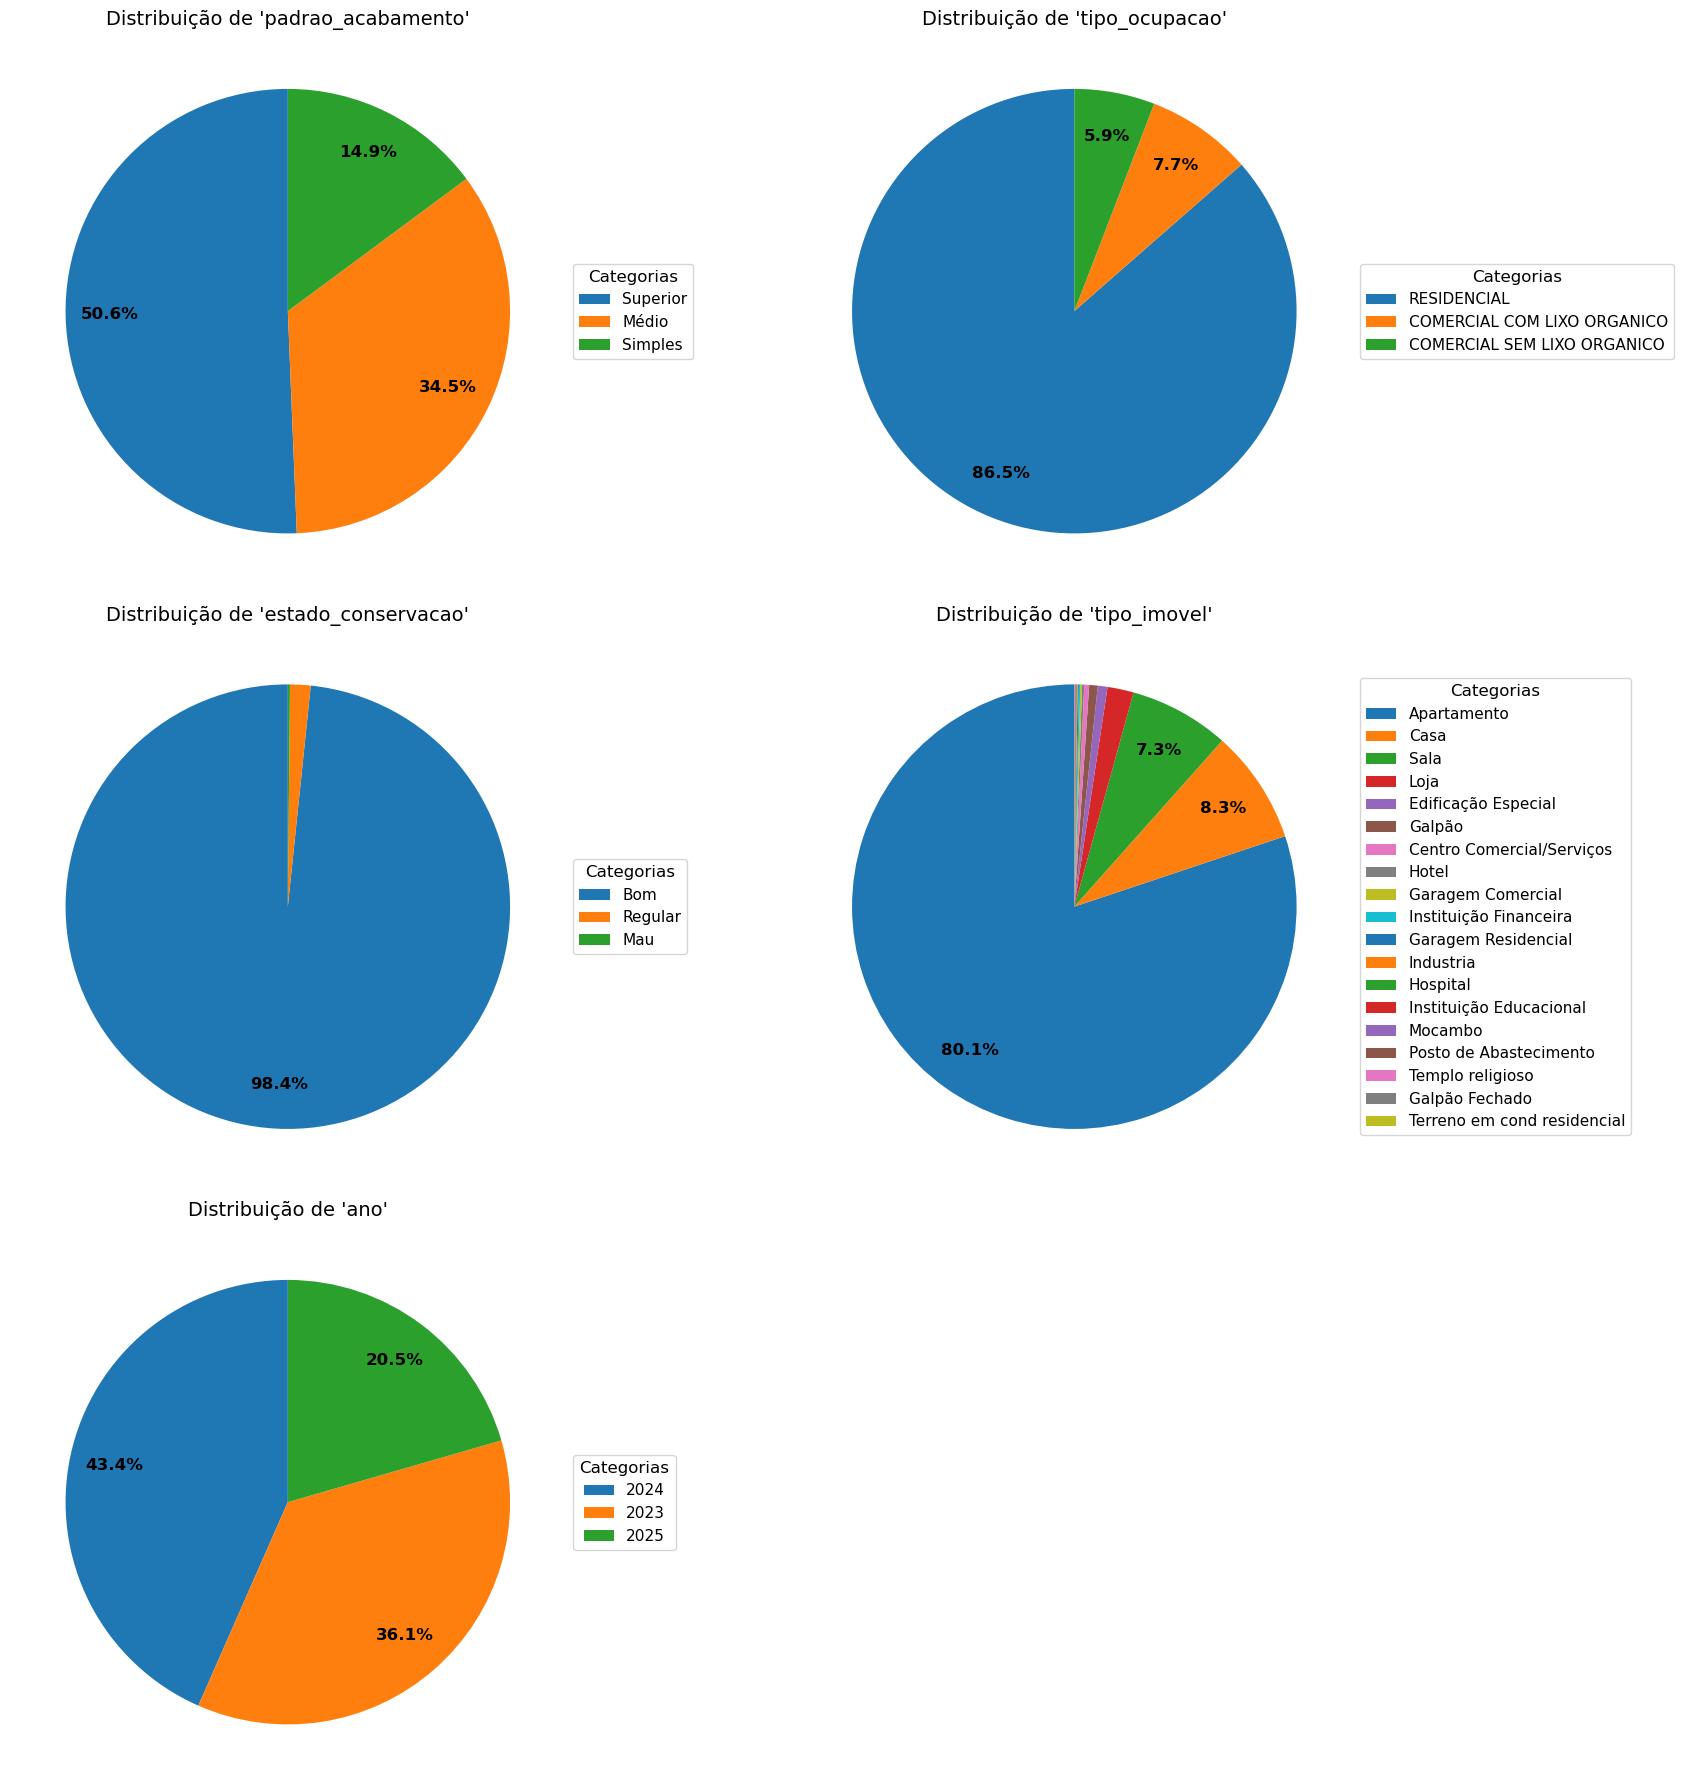

In [426]:
# Pie charts for each categorical column, with improved spacing and no number overlap

categorical_columns = staging_dataset.select_dtypes(include=["category"]).columns
n_cols = 2
n_rows = math.ceil(len(categorical_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(9 * n_cols, 6 * n_rows))  # Increased figure size
axes = axes.flatten() if len(categorical_columns) > 1 else [axes]

for idx, col in enumerate(categorical_columns):
    value_counts = staging_dataset[col].value_counts(dropna=True)
    if len(value_counts) > 1:
        wedges, texts, autotexts = axes[idx].pie(
            value_counts,
            autopct=lambda pct: f'{pct:.1f}%' if pct > 2 else '',  # Hide small percentages
            startangle=90,
            labels=None,
            pctdistance=0.8,    # Move percentage labels outward
            labeldistance=1.1,  # Move category labels outward (if used)
        )
        # Make percentage labels larger and bold for readability
        for autotext in autotexts:
            autotext.set_fontsize(12)
            autotext.set_fontweight('bold')
            axes[idx].set_title(f"Distribuição de '{col}'", fontsize=14)
            axes[idx].set_ylabel("")
            axes[idx].legend(
                wedges,
                value_counts.index,
                title="Categorias",
                loc="center left",
                bbox_to_anchor=(1, 0, 0.5, 1),
                fontsize=11,
                title_fontsize=12
            )
    else:
        axes[idx].axis('off')

for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**By numerical values**

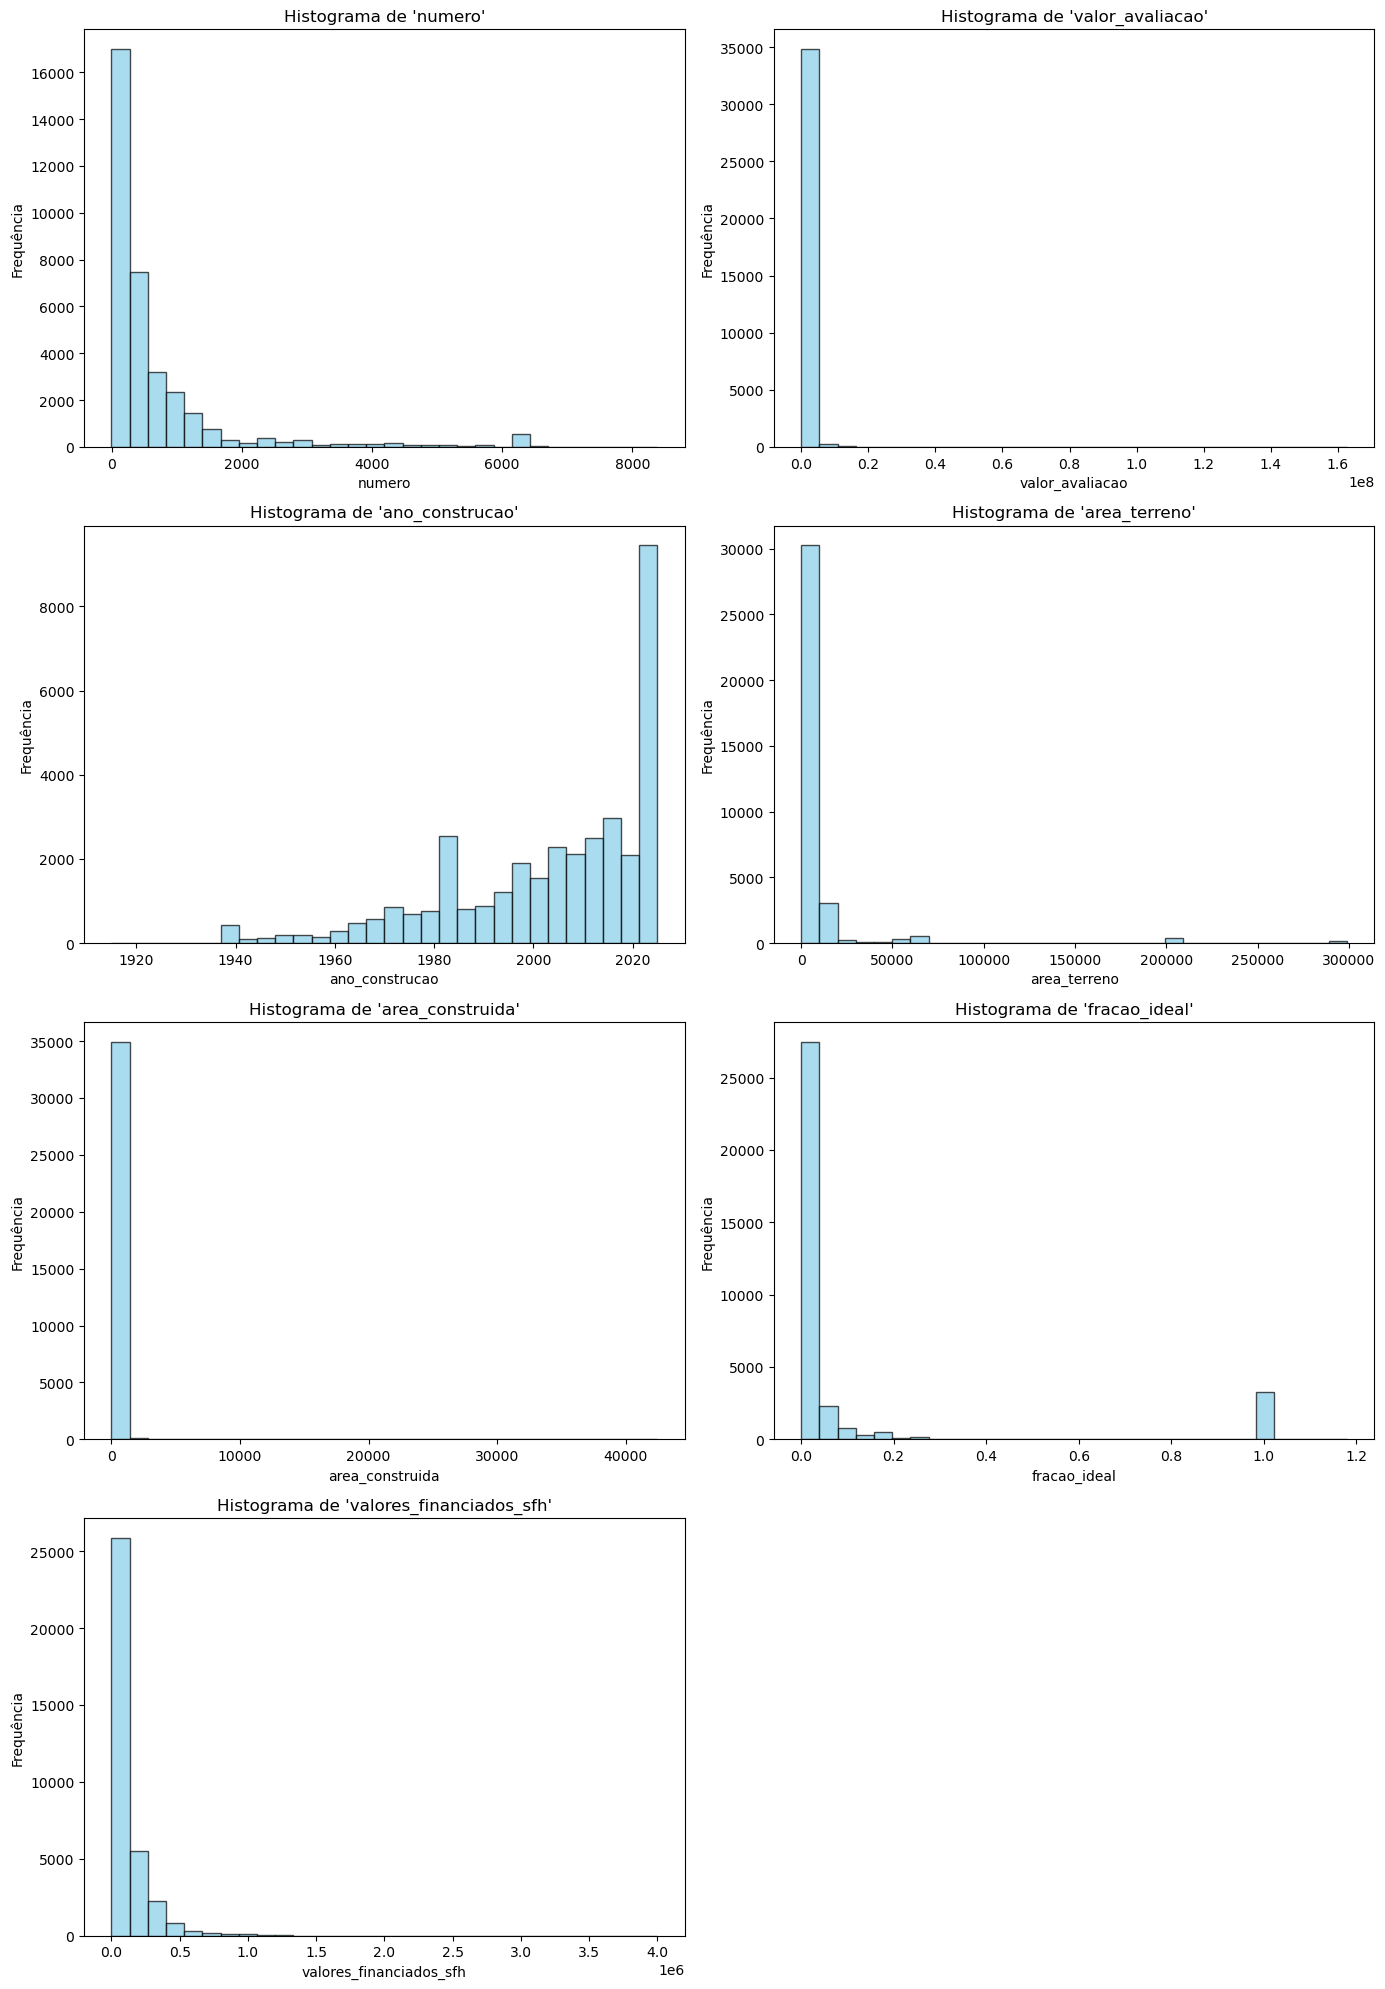

In [427]:
# Unidimensional visualizations (histograms and boxplots) for selected numerical columns (excluding unwanted columns)

import matplotlib.pyplot as plt

# Select numerical columns, excluding specific ones
exclude_cols = ["cod_logradouro", "latitude", "longitude"]
numerical_columns = [
    col for col in staging_dataset.select_dtypes(include=["int64", "float64"]).columns
    if col not in exclude_cols
]

n_cols = 2
n_rows = (len(numerical_columns) + 1) // n_cols

# Histograms
fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 5 * n_rows))
axes = axes.flatten() if len(numerical_columns) > 1 else [axes]

for idx, col in enumerate(numerical_columns):
    ax = axes[idx]
    staging_dataset[col].plot.hist(
        bins=30,
        alpha=0.7,
        ax=ax,
        color='skyblue',
        edgecolor='black'
    )
    ax.set_title(f"Histograma de '{col}'")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequência")

for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Data normalization

**create primary key**

In [428]:
def add_row_id(df, id_column='id'):
    """
    Adds a unique sequential ID for each row in the DataFrame as the first column.

    Args:
        df (pd.DataFrame): The DataFrame to process.
        id_column (str): Name of the new ID column.

    Returns:
        pd.DataFrame: DataFrame with the ID column as the first column.
    """
    df_with_id = df.copy()
    df_with_id[id_column] = range(1, len(df_with_id) + 1)
    # Move the id column to the first position
    cols = [id_column] + [col for col in df_with_id.columns if col != id_column]
    return df_with_id[cols]

staging_dataset = add_row_id(staging_dataset)
staging_dataset.head()

,id,logradouro,numero,complemento,valor_avaliacao,bairro,ano_construcao,area_terreno,area_construida,fracao_ideal,...,tipo_ocupacao,data_transacao,estado_conservacao,tipo_imovel,valores_financiados_sfh,cod_logradouro,latitude,longitude,ano,quantidade_pavimentos
0,1,av norte miguel arraes de alencar,3071,não informado,1068562.63,Encruzilhada,1997,438.00,511.00,1.00000,...,COMERCIAL COM LIXO ORGANICO,2023-12-21,Regular,Galpão,0.0,46540,-8.034273,-34.896337,2023,não especificado
1,2,av norte miguel arraes de alencar,3029,não informado,1500000.00,Encruzilhada,1957,779.33,582.44,1.00000,...,COMERCIAL SEM LIXO ORGANICO,2023-11-17,Regular,Casa,0.0,46540,-8.034435,-34.896335,2023,não especificado
2,3,rua belmiro corrêa,133,apto 0001,110000.00,Encruzilhada,1970,562.05,121.00,0.27191,...,RESIDENCIAL,2023-09-26,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,<= 4 pavimentos
3,4,rua belmiro corrêa,133,apto 0001,110000.00,Encruzilhada,1970,562.05,121.00,0.27191,...,RESIDENCIAL,2023-09-22,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,<= 4 pavimentos
4,5,rua belmiro corrêa,133,apto 0002,110000.00,Encruzilhada,1970,562.05,81.00,0.18202,...,RESIDENCIAL,2023-09-22,Bom,Apartamento,0.0,10715,-8.035013,-34.895903,2023,<= 4 pavimentos


In [429]:
def create_primary_key(df, key_columns, conflict_strategy='first', verbose=True, show_examples=2):
    """
    Creates a primary key by keeping only one row for each duplicate key.
    For columns with conflicting values, shows an example of the conflict for each column.
    """
    duplicates = df[df.duplicated(subset=key_columns, keep=False)]
    if verbose and not duplicates.empty:
        print(f"Found {len(duplicates)} rows with duplicate primary key ({key_columns}).")
        for col in df.columns:
            if col not in key_columns:
                nunique = duplicates.groupby(key_columns)[col].nunique()
                conflict_keys = nunique[nunique > 1].index
                if len(conflict_keys) > 0:
                    print(f"\nColumn '{col}' has conflicting values for {len(conflict_keys)} keys. Example(s):")
                    for i, key in enumerate(conflict_keys):
                        if i >= show_examples:
                            break
                        # Handle single-column and multi-column keys
                        if isinstance(key, tuple):
                            key_dict = dict(zip(key_columns, key))
                            mask = (df[key_columns] == pd.Series(key, index=key_columns)).all(axis=1)
                        else:
                            key_dict = {key_columns[0]: key}
                            mask = df[key_columns[0]] == key
                        rows = df.loc[mask]
                        print(f"  Key: {key_dict}")
                        display(rows[[*key_columns, col]])
    if conflict_strategy == 'first':
        df_clean = df.drop_duplicates(subset=key_columns, keep='first').reset_index(drop=True)
    elif conflict_strategy == 'last':
        df_clean = df.drop_duplicates(subset=key_columns, keep='last').reset_index(drop=True)
    elif conflict_strategy == 'random':
        df_clean = df.sample(frac=1).drop_duplicates(subset=key_columns, keep='first').reset_index(drop=True)
    else:
        raise ValueError("conflict_strategy must be 'first', 'last', or 'random'")
    if verbose:
        print(f"\nResulting DataFrame has {len(df_clean)} unique rows by primary key {key_columns}.")
    return df_clean

In [430]:
def normalize_logradouro(df):
    """
    Normalizes the DataFrame by splitting logradouro information into a separate table.

    Args:
        df (pd.DataFrame): Original DataFrame containing cod_logradouro, logradouro.

    Returns:
        tuple: (df_main, df_logradouro)
            df_main: Original DataFrame without the logradouro and bairro columns.
            df_logradouro: Table with unique cod_logradouro, nome_logradouro pairs.
    """
    # Create the logradouro table (unique pairs, renaming column)
    df_logradouro = (
        df[['cod_logradouro', 'logradouro']]
        .drop_duplicates()
        .rename(columns={'logradouro': 'nome_logradouro'})
        .reset_index(drop=True)
    )
    # Normalize using create_primary_key (fix for single-column key)
    df_logradouro = create_primary_key(
        df_logradouro,
        key_columns=['cod_logradouro'],
        conflict_strategy='first',
        verbose=True,
        show_examples=5,
    )
    # Remove logradouro and bairro columns from main table
    df_main = df.drop(columns=['logradouro'])
    return df_main, df_logradouro

staging_dataset, logradouro_table = normalize_logradouro(staging_dataset)
logradouro_table.head()

Found 204 rows with duplicate primary key (['cod_logradouro']).

Column 'nome_logradouro' has conflicting values for 101 keys. Example(s):
  Key: {'cod_logradouro': 1147}


,cod_logradouro,nome_logradouro
346,1147,av engenheiro agamenon de magalhaes melo
349,1147,av eng agamenon de magalhaes melo


  Key: {'cod_logradouro': 1155}


,cod_logradouro,nome_logradouro
79,1155,av governador agamenon magalhaes
111,1155,av gov agamenon magalhaes
1984,1155,av governador agamenon magalhães


  Key: {'cod_logradouro': 3646}


,cod_logradouro,nome_logradouro
638,3646,rua comendador alvares de carvalho
639,3646,rua comda alvares de carvalho


  Key: {'cod_logradouro': 3719}


,cod_logradouro,nome_logradouro
514,3719,rua prof alvaro lima
515,3719,rua professor alvaro lima


  Key: {'cod_logradouro': 3786}


,cod_logradouro,nome_logradouro
1229,3786,av engenheiro alves de souza
1231,3786,av eng alves de souza



Resulting DataFrame has 2008 unique rows by primary key ['cod_logradouro'].


,cod_logradouro,nome_logradouro
0,46540,av norte miguel arraes de alencar
1,10715,rua belmiro corrêa
2,13269,rua caio pereira
3,53996,av santos dumont
4,36196,rua doutor jose maria


In [431]:
def normalize_locations(df):
    """
    Normalizes the DataFrame by splitting bairro, latitude and longitude information into a separate table.

    Args:
        df (pd.DataFrame): Original DataFrame containing cod_logradouro, numero, bairro, latitude and longitude.

    Returns:
        tuple: (df_main, df_bairro)
            df_main: Original DataFrame without the bairro column.
            df_bairro: Table with unique (cod_logradouro, numero) as primary key and bairro, longitude and latitude.
    """
    # Create the bairro table (unique pairs)
    df_locations = (
        df[['cod_logradouro', 'numero', 'bairro', 'latitude', 'longitude']]
        .drop_duplicates()
        .reset_index(drop=True)
    )
    # Normalize using create_primary_key for composite key
    df_locations = create_primary_key(
        df_locations,
        key_columns=['cod_logradouro', 'numero'],
        conflict_strategy='first',
        verbose=True,
        show_examples=5,
    )
    # Remove bairro column from main table
    df_main = df.drop(columns=['bairro', 'latitude', 'longitude'])
    return df_main, df_locations

staging_dataset, locations_table = normalize_locations(staging_dataset)
locations_table.head()

Found 164 rows with duplicate primary key (['cod_logradouro', 'numero']).

Column 'bairro' has conflicting values for 49 keys. Example(s):
  Key: {'cod_logradouro': 1791, 'numero': 173}


,cod_logradouro,numero,bairro
4329,1791,173,Graças
4330,1791,173,Gracas


  Key: {'cod_logradouro': 4375, 'numero': 94}


,cod_logradouro,numero,bairro
4475,4375,94,Gracas
6652,4375,94,Graças


  Key: {'cod_logradouro': 4375, 'numero': 109}


,cod_logradouro,numero,bairro
4483,4375,109,Gracas
6654,4375,109,Graças


  Key: {'cod_logradouro': 5622, 'numero': 934}


,cod_logradouro,numero,bairro
1809,5622,934,Varzea
6927,5622,934,Várzea


  Key: {'cod_logradouro': 6017, 'numero': 241}


,cod_logradouro,numero,bairro
223,6017,241,Gracas
6606,6017,241,Graças



Column 'latitude' has conflicting values for 18 keys. Example(s):
  Key: {'cod_logradouro': 1465, 'numero': 1350}


,cod_logradouro,numero,latitude
2990,1465,1350,-8.101299
2991,1465,1350,-8.101369
2992,1465,1350,-8.101495
2993,1465,1350,-8.101864
6005,1465,1350,-8.101552
6006,1465,1350,-8.101620
6007,1465,1350,-8.101748
6008,1465,1350,-8.101999


  Key: {'cod_logradouro': 9164, 'numero': 1295}


,cod_logradouro,numero,latitude
336,9164,1295,-8.053501
337,9164,1295,-8.053193


  Key: {'cod_logradouro': 9792, 'numero': 94}


,cod_logradouro,numero,latitude
5758,9792,94,-8.081054
5759,9792,94,-8.081166


  Key: {'cod_logradouro': 16420, 'numero': 100}


,cod_logradouro,numero,latitude
5946,16420,100,-8.089476
5947,16420,100,-8.089370


  Key: {'cod_logradouro': 17710, 'numero': 204}


,cod_logradouro,numero,latitude
5615,17710,204,-8.047248
5616,17710,204,-8.047780



Column 'longitude' has conflicting values for 18 keys. Example(s):
  Key: {'cod_logradouro': 1465, 'numero': 1350}


,cod_logradouro,numero,longitude
2990,1465,1350,-34.887508
2991,1465,1350,-34.887199
2992,1465,1350,-34.887257
2993,1465,1350,-34.887428
6005,1465,1350,-34.887627
6006,1465,1350,-34.887315
6007,1465,1350,-34.887374
6008,1465,1350,-34.887490


  Key: {'cod_logradouro': 9164, 'numero': 1295}


,cod_logradouro,numero,longitude
336,9164,1295,-34.876255
337,9164,1295,-34.876535


  Key: {'cod_logradouro': 9792, 'numero': 94}


,cod_logradouro,numero,longitude
5758,9792,94,-34.911357
5759,9792,94,-34.911359


  Key: {'cod_logradouro': 16420, 'numero': 100}


,cod_logradouro,numero,longitude
5946,16420,100,-34.912254
5947,16420,100,-34.912230


  Key: {'cod_logradouro': 17710, 'numero': 204}


,cod_logradouro,numero,longitude
5615,17710,204,-34.958227
5616,17710,204,-34.958370



Resulting DataFrame has 7252 unique rows by primary key ['cod_logradouro', 'numero'].


,cod_logradouro,numero,bairro,latitude,longitude
0,46540,3071,Encruzilhada,-8.034273,-34.896337
1,46540,3029,Encruzilhada,-8.034435,-34.896335
2,10715,133,Encruzilhada,-8.035013,-34.895903
3,10715,109,Encruzilhada,-8.035165,-34.895961
4,13269,800,Encruzilhada,NaN,NaN


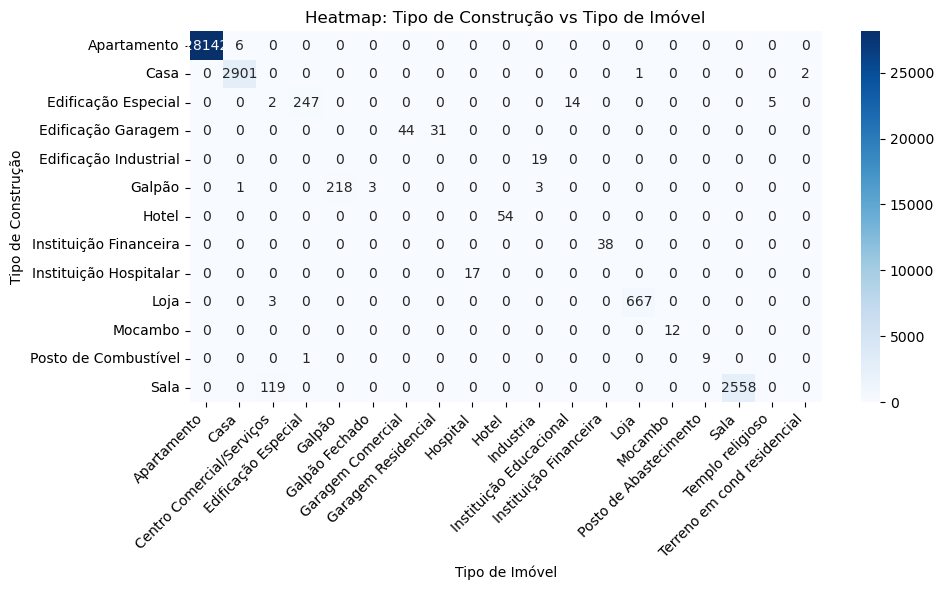

In [432]:
# Heatmap between tipo_construcao and tipo_imovel
heatmap_data = pd.crosstab(staging_dataset['tipo_construcao'], staging_dataset['tipo_imovel'])

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Heatmap: Tipo de Construção vs Tipo de Imóvel")
plt.xlabel("Tipo de Imóvel")
plt.ylabel("Tipo de Construção")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#  DATABASE PREPARATION - POSTGRESQL INSERTION

## Preparing Consolidated Dataset for Database Storage
Now we'll prepare our transformed and validated ITBI dataset for insertion into PostgreSQL database. This includes database connection setup and data preparation.